# Library imports

In [404]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance

np.warnings.filterwarnings('ignore')

# Functions and Classes

In [405]:
def get_point_coordinate_from_pixel_coordinate(pixel_coordinate, point_precision):
    """
    Adjusts the coordinates of a pixel to the coordinates of the point it corresponds to.
    
    Args:
        - pixel_coordinate: the coordinate of a pixel, only a singel axis.
        - point_precision: the precision of the groundtruth.
    Returns:
        - the coordinate of the point the pixel corresponds to.
    """
    floor_divided_pixel = pixel_coordinate // (point_precision/2)
    if floor_divided_pixel % 2:
        return floor_divided_pixel * (point_precision/2)
    else:
        return (floor_divided_pixel + 1) * (point_precision/2)

In [413]:
class FeatureExtractor:
    """
    Extracts the features of each point based on the pixels inside it.
    
    Attributes
    ----------
    input_data : Pandas DataFrame
        LiDAR input information with the coordinates of the points corresponding to each pixel.
    
    Methods
    -------
    mean_height(name='mean_height')
    num_pixels(name='num_pixels')
    num_ground(name='num_ground')
    num_low_vegetation(name='num_low_vegetation')
    num_medium_vegetation(name='num_medium_vegetation')
    num_high_vegetation(name='num_high_vegetation')
    num_building(name='num_building')
    num_low_point(name='num_low_point')
    max_height_diff(name='max_height_diff')
    
    """
    
    def __init__(self, input_data, block_height_grouping=6):
        
        if not set(['x_p', 'y_p', 'x', 'y', 'c', 'a']).issubset(set(input_data.columns)):
            print("Error: Input data does not have the required columns")
            
        self.xp = 'x_p'      # pixel's point x coordinate column name
        self.yp = 'y_p'      # pixel's point y coordinate column name
        self.x = 'x'         # pixel x coordinate column name
        self.y = 'y'         # pixel y coordinate column name
        self.c = 'c'         # pixel class column name
        self.a = 'a'         # pixel angle columns name

        self.data = self._get_heights(input_data, block_height_grouping)  # LiDAR data with point-assigned pixels and its height
        self.grouped = self.data.groupby([self.xp, self.yp]) # pixels grouped by point
          
        
    def _get_heights(self, input_data, grouping):
        input_data['height_merging_x'] = ( input_data[self.x] // grouping ) * grouping
        input_data['height_merging_y'] = ( input_data[self.y] // grouping ) * grouping

        input_copy = input_data.copy()

        input_copy = input_copy.groupby(['height_merging_x', 'height_merging_y'])['z'].min().reset_index()
        input_copy = input_copy.rename({'z':'surface_z'}, axis=1)

        input_data = pd.merge(input_data, input_copy, how='left', on=['height_merging_x', 'height_merging_y'])
        input_data['height'] = input_data['z'] - input_data['surface_z']

        input_data = input_data.drop(['z', 'surface_z', 'height_merging_x', 'height_merging_y'], axis=1)
        
        return input_data
    
    def not_cassified_pts(self, name='not_classified_pts'):
        # NEW
        '''
        Number of points that are not vegetation nor ground.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)        
        '''
        aux_arr = self.data.query('@self.c not in [3, 4, 5, 6, 7]').copy()
        
        aux_arr.groupby([self.xp, self.yp])[self.c].count()
        return aux_arr.rename(name, inplace=True)
        
           
    def angle_mean(self, name='angle_mean'):
        # NEW
        '''
        Mean angle of scanning.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        '''
        values = self.grouped[self.a].mean()
        return values.rename(name, inplace=True)
    
    def angle_quantile(self, quant=0.5, name='angle_Q'):
        # NEW
        """
        Quantile value of the height array of that point.
        
        Parameters
        ----------
        quant: Percentage of the quantile. Range: [0,1]
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        values = self.grouped[self.a].quantile(quant)
        return values.rename(name+str(quant), inplace=True)
    
    def angle_sd(self, name='angle_sd'):
        # NEW
        '''
        The standard deviation of the angle Array of that point.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        '''
        values = self.grouped[self.a].std()
        return values.rename(name, inplace=True)
    
    def angle_max_diff(self, name='angle_max_diff'):
        # NEW
        """
        The difference between the highest angle and the lowest angleu.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        values = self.grouped[self.a].max()
        return values.rename(name, inplace=True)
    
    def height_quantile(self, quant, name='height_Q'):
        """
        Quantile value of the height array of that point.
        
        Parameters
        ----------
        quant: Percentage of the quantile. Range: [0,1]
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        values = self.grouped['height'].quantile(quant)
        return values.rename(name+str(quant), inplace=True)
        
    def threshold_percentage(self, threshold, name='above_threshold_pct'):
        """
        Percentage of points above a certain threshold.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        my_block = self.data.copy()
        df_canopy = my_block.query('height > @threshold').copy()

        df_canopy['counted_canopy'] = np.zeros(df_canopy.shape[0])
        df_canopy = df_canopy.groupby([self.xp, self.yp])[['counted_canopy']].count().reset_index()

        my_block['counted_no_canopy'] = np.zeros(my_block.shape[0])
        my_block = my_block.groupby([self.xp, self.yp])[['counted_no_canopy']].count().reset_index()

        my_block = pd.merge(my_block, df_canopy, how='left', on = [self.xp, self.yp])

        my_block['counted_canopy'].fillna(0, inplace=True)
        my_block[name] = 100*my_block['counted_canopy'] / my_block['counted_no_canopy']
        
        my_block.drop(['counted_canopy', "counted_no_canopy"], axis=1, inplace = True)
        
        return my_block
    
    def sd_height(self, name='sd_height'):
        '''
        The standard deviation of the height Array of that point.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        '''
        values = self.grouped['height'].std()
        return values.rename(name, inplace=True)
        
    def max_height_diff(self, name='max_height_diff'):
        """
        The difference between the highest LiDAR point and the lowest LiDAR point.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        values = self.grouped['height'].max()
        return values.rename(name, inplace=True)
    
    def mean_height(self, name='mean_height'):
        """
        Mean height with respect to the geoid.
         
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        values = self.grouped['height'].mean()
        return values.rename(name, inplace=True)
    
    def num_pixels(self, name='num_pixels'):
        """
        Number of pixels of each point.
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        values = self.grouped.count()[self.x]
        return values.rename(name, inplace=True)
    
    def num_ground(self, name='num_ground'):
        """
        Number of pixels classified as "ground".
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        filtered = self.data[self.data[self.c]==2] # 2 corresponds to "low vegetation"
        values = filtered.groupby([self.xp, self.yp]).count()[self.x]
        return values.rename(name, inplace=True)
    
    def num_low_vegetation(self, name='num_low_vegetation'):
        """
        Number of pixels classified as "low vegetation".
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        filtered = self.data[self.data[self.c]==3] # 3 corresponds to "low vegetation"
        values = filtered.groupby([self.xp, self.yp]).count()[self.x]
        return values.rename(name, inplace=True)
    
    def num_medium_vegetation(self, name='num_medium_vegetation'):
        """
        Number of pixels classified as "medium vegetation".
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        filtered = self.data[self.data[self.c]==4] # 4 corresponds to "low vegetation"
        values = filtered.groupby([self.xp, self.yp]).count()[self.x]
        return values.rename(name, inplace=True)
    
    def num_high_vegetation(self, name='num_high_vegetation'):
        """
        Number of pixels classified as "high vegetation".
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        filtered = self.data[self.data[self.c]==5] # 5 corresponds to "high vegetation"
        values = filtered.groupby([self.xp, self.yp]).count()[self.x]
        return values.rename(name, inplace=True)
    
    def num_building(self, name='num_building'):
        """
        Number of pixels classified as "building".
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        filtered = self.data[self.data[self.c]==6] # 6 corresponds to "building"
        values = filtered.groupby([self.xp, self.yp]).count()[self.x]
        return values.rename(name, inplace=True)
    
    def num_low_point(self, name='num_low_point'):
        """
        Number of pixels classified as "low point".
        
        Parameters
        ----------
        name : name of the resulting series object (that will eventually be the column name in the dataset)
        """
        filtered = self.data[self.data[self.c]==7] # 7 corresponds to "low point"
        values = filtered.groupby([self.xp, self.yp]).count()[self.x]
        return values.rename(name, inplace=True)


# Script

In [414]:
# Constants
toy_gt_path = '../toy dataset/groundtruth_toydataset.csv'
toy_input_path = '../toy dataset/input_toydataset.txt'
nonzero_gt_path = '../nonzerogt_dataset/groundtruth_nonzerogt.csv'
nonzero_input_path = '../nonzerogt_dataset/input_nonzerogt.txt'

groundtruth_datapath = toy_gt_path                                  # Where the groundturh data is stored
groundtruth_columns = ['x', 'y', 'CC']                              # Groundturth data columns
groundtruth_precision = 20                                          # Groundturth precision in meters
input_datapath = toy_input_path                                     # Where the input data is storedº
input_columns = ['x','y','z', 'c']                                  # Input data columns

### Creation of the dataset

In [415]:
# LiDAR and groundtruth reading
my_block = pd.read_csv(input_datapath, sep=' ', header = None, names = input_columns)
groundtruth = pd.read_csv(groundtruth_datapath, sep=' ', header = None, names = groundtruth_columns)

In [416]:
# Adding the corresponding point coordinates to each pixel
my_block['x_p'] = my_block.apply(lambda pixel: get_point_coordinate_from_pixel_coordinate(pixel['x'], groundtruth_precision), axis=1)
my_block['y_p'] = my_block.apply(lambda pixel: get_point_coordinate_from_pixel_coordinate(pixel['y'], groundtruth_precision), axis=1)

In [417]:
# Creating the final dataset
data = groundtruth.copy()
    # Necessary in order to merge later
data.rename(columns={"x": "x_p", "y": "y_p"}, inplace=True)

In [418]:
# Creating the feature extractor object
FE = FeatureExtractor(my_block, 6)

Error: Input data does not have the required columns


In [419]:
# Adding the features to the dataset

data = data.merge(FE.mean_height(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.num_pixels(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.num_ground(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.num_low_vegetation(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.num_medium_vegetation(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.num_high_vegetation(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.num_building(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.max_height_diff(), how='left', on=['x_p', 'y_p'])
data = data.merge(FE.sd_height(), how='left', on=['x_p', 'y_p'])
# data = data.merge(FE.not_cassified_pts(), how='left', on=['x_p', 'y_p'])
# data = data.merge(FE.angle_mean(), how='left', on=['x_p', 'y_p'])
# data = data.merge(FE.angle_sd(), how='left', on=['x_p', 'y_p'])
# data = data.merge(FE.angle_max_diff(), how='left', on=['x_p', 'y_p'])
# for q in [0.2,0.4,0.6,0.8]:
    # data = data.merge(FE.angle_quantile(q), how='left', on=['x_p', 'y_p'])
for q in [0.2,0.4,0.6,0.8]:
    data = data.merge(FE.height_quantile(q), how='left', on=['x_p', 'y_p'])
for t in [2.5,3,3.5]:
    data = data.merge(FE.threshold_percentage(t), how='left', on=['x_p', 'y_p'])


data.fillna(0, inplace=True)

In [422]:
# Showing some rows to check if it looks as expected
data[0:5]

,x_p,y_p,CC,mean_height,num_pixels,num_ground,num_low_vegetation,num_medium_vegetation,num_high_vegetation,num_building,max_height_diff,sd_height,height_Q0.2,height_Q0.4,height_Q0.6,height_Q0.8,above_threshold_pct_x,above_threshold_pct_y,above_threshold_pct
0,396030.0,4591970.0,63.66,6.995334,163,3.0,13.0,13.0,94.0,0.0,21.9098,6.540226,0.26380,3.02990,8.01632,14.57012,65.030675,60.736196,52.760736
1,396050.0,4591970.0,0.00,1.226660,156,27.0,11.0,10.0,16.0,0.0,10.2000,1.782088,0.06000,0.25020,0.45990,2.84980,23.717949,15.384615,5.769231
2,396070.0,4591970.0,0.00,0.488175,155,22.0,3.0,0.0,0.0,0.0,2.5197,0.450790,0.12960,0.29000,0.55004,0.72978,0.645161,0.000000,0.000000
3,396090.0,4591970.0,19.44,1.210338,167,11.0,10.0,8.0,14.0,0.0,7.0497,1.455852,0.18174,0.46782,0.92600,1.90198,11.377246,10.179641,8.982036
4,396110.0,4591970.0,0.00,0.852910,157,32.0,10.0,4.0,9.0,0.0,9.0503,1.724072,0.07000,0.15984,0.25610,1.06612,7.006369,7.006369,7.006369


### EDA

In [423]:
data.shape

(952, 19)

In [424]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 952 entries, 0 to 951
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   x_p                    952 non-null    float64
 1   y_p                    952 non-null    float64
 2   CC                     952 non-null    float64
 3   mean_height            952 non-null    float64
 4   num_pixels             952 non-null    int64  
 5   num_ground             952 non-null    float64
 6   num_low_vegetation     952 non-null    float64
 7   num_medium_vegetation  952 non-null    float64
 8   num_high_vegetation    952 non-null    float64
 9   num_building           952 non-null    float64
 10  max_height_diff        952 non-null    float64
 11  sd_height              952 non-null    float64
 12  height_Q0.2            952 non-null    float64
 13  height_Q0.4            952 non-null    float64
 14  height_Q0.6            952 non-null    float64
 15  height

In [425]:
data.describe()

,x_p,y_p,CC,mean_height,num_pixels,num_ground,num_low_vegetation,num_medium_vegetation,num_high_vegetation,num_building,max_height_diff,sd_height,height_Q0.2,height_Q0.4,height_Q0.6,height_Q0.8,above_threshold_pct_x,above_threshold_pct_y,above_threshold_pct
count,952.000000,9.520000e+02,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000
mean,396360.000000,4.591700e+06,33.971250,3.936884,234.607143,16.679622,27.257353,9.255252,77.781513,0.052521,14.121180,3.627638,0.602892,1.898581,4.702787,7.127928,34.371550,31.982846,30.088363
std,196.317304,1.616399e+02,39.976737,3.617767,216.037436,21.482081,46.538542,18.234164,118.210601,1.119267,26.844234,3.208248,0.778796,2.562563,5.159246,6.582639,29.417091,28.374709,27.355904
min,396030.000000,4.591430e+06,0.000000,0.138614,115.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.490100,0.123542,0.020180,0.060260,0.090320,0.140000,0.000000,0.000000,0.000000
25%,396190.000000,4.591565e+06,0.000000,0.466121,145.000000,4.000000,9.000000,0.000000,0.000000,0.000000,2.785225,0.560745,0.115985,0.249930,0.382110,0.589325,0.735412,0.000000,0.000000
50%,396360.000000,4.591700e+06,0.000000,2.757624,173.000000,11.000000,17.000000,4.000000,52.000000,0.000000,13.520100,3.588754,0.199980,0.539060,1.699930,5.557260,33.650423,30.982088,28.496241
75%,396530.000000,4.591835e+06,71.095000,6.990717,242.000000,21.000000,30.000000,12.000000,113.000000,0.000000,19.472400,5.943417,0.915865,2.965265,9.022475,13.063745,63.114440,59.886025,56.818182
max,396690.000000,4.591970e+06,151.390000,23.778701,1930.000000,201.000000,550.000000,219.000000,1269.000000,32.000000,514.309800,29.560237,8.503960,22.200100,36.929800,40.459800,90.975747,89.847716,88.494078


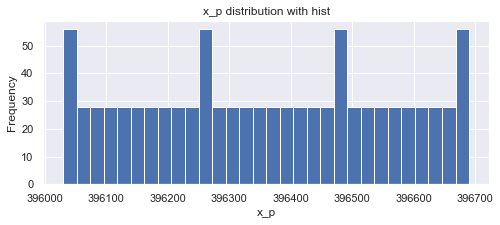

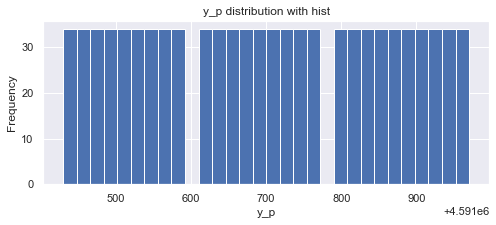

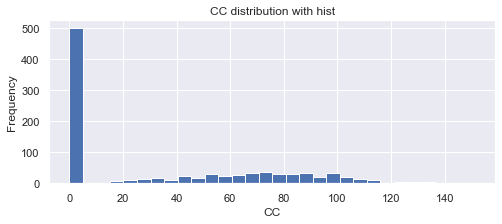

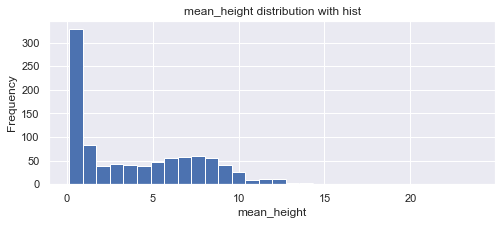

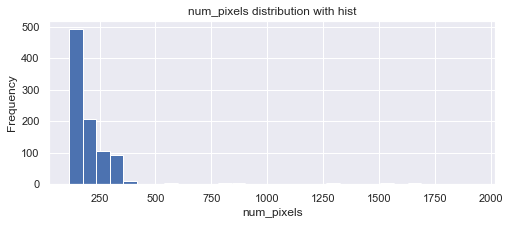

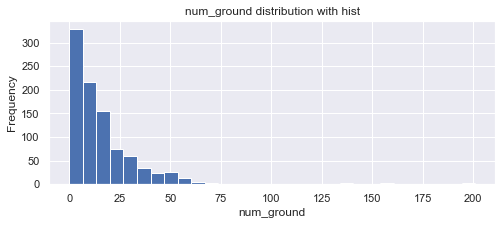

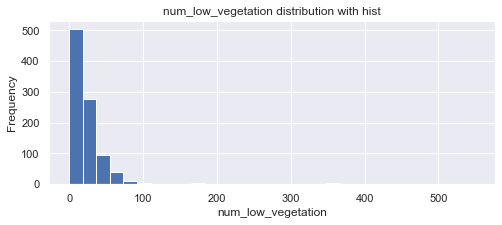

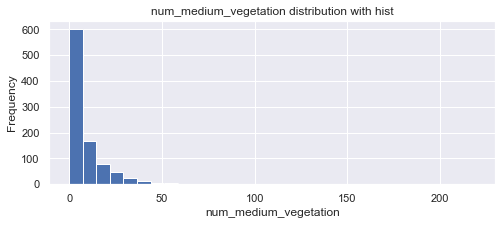

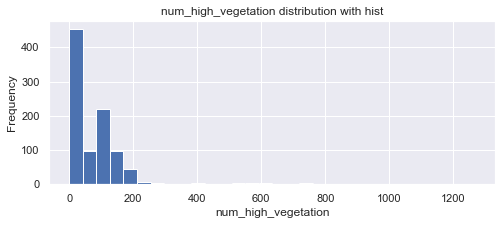

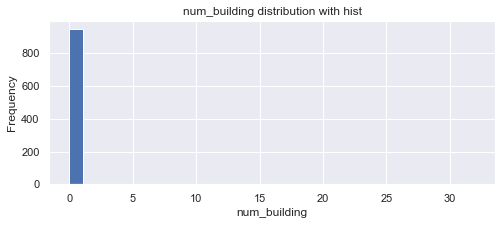

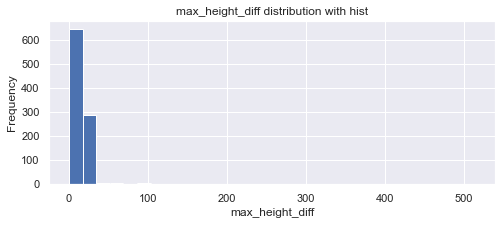

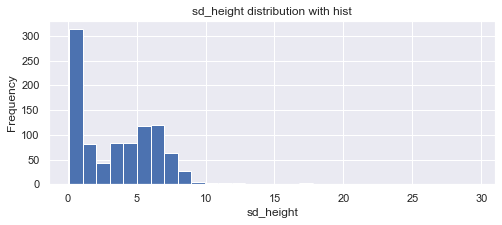

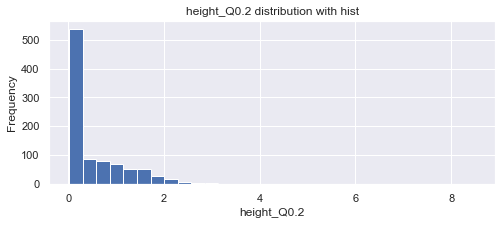

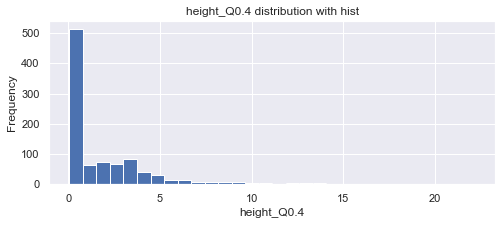

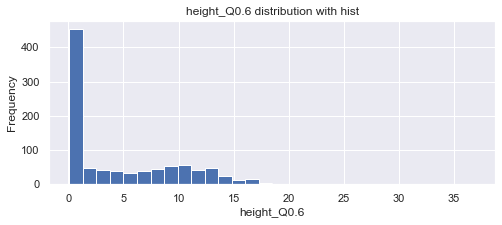

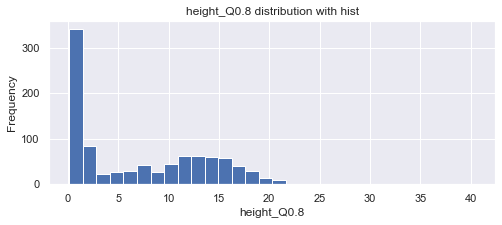

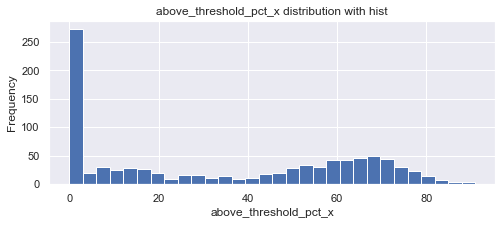

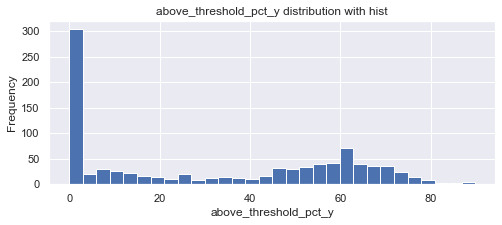

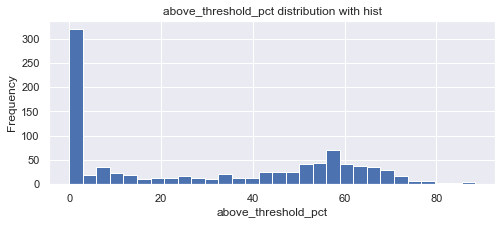

In [426]:
def plot_hist(variable):
    plt.figure(figsize = (8,3))
    plt.hist(data[variable], bins = 30)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()

for n in data.columns:
    if pd.api.types.is_numeric_dtype(data[n]):
        plot_hist(n)

<AxesSubplot:>

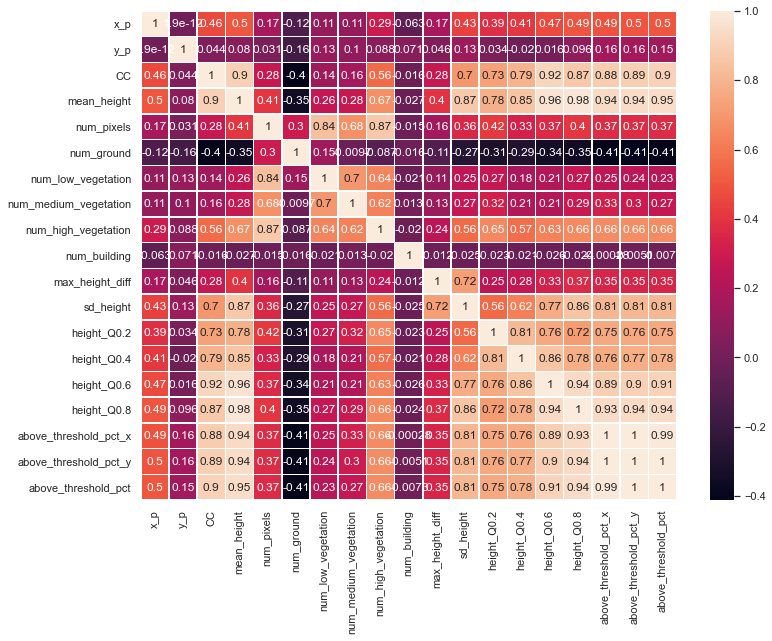

In [427]:
correlations = data.corr()
sns.set(rc={'figure.figsize':(12,9)})
sns.heatmap(correlations, annot=True, linewidth=.5)

### Data splitting

In [428]:
# Attributes-Target division
X = data.loc[:, data.columns != "CC"]
y = data['CC']

In [429]:
# Data normalization
scaler = StandardScaler()
scaler.fit(X)
std_X = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [430]:
# Train-test division 
X_train, X_test, y_train, y_test = train_test_split(std_X, y, test_size=0.2, random_state=123)

### Multiple linear regression model

In [431]:
reg = LinearRegression().fit(std_X, y)
preds = reg.predict(std_X)

<function matplotlib.pyplot.show(close=None, block=None)>

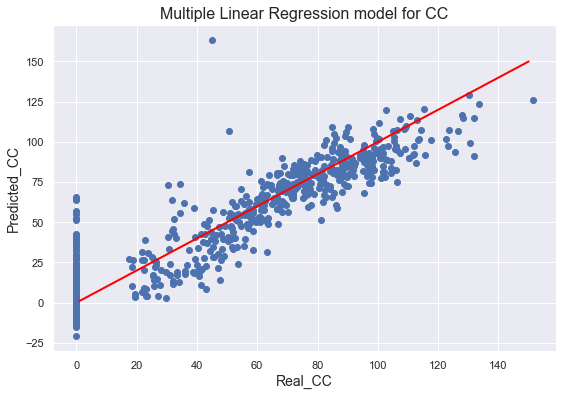

In [432]:
plt.rcParams["figure.figsize"] = (9,6)
plt.scatter(x=y, y=preds)
plt.plot([1,150], [1,150], color="red", linewidth=2)
plt.xlabel("Real_CC", fontsize=14)
plt.ylabel("Predicted_CC", fontsize=14)
plt.title("Multiple Linear Regression model for CC", fontsize=16)
plt.show

In [433]:
r2_score(y, preds)

0.8939349370699043

### Random forest regressor model

In [434]:
regressor = RandomForestRegressor(n_estimators=10, random_state=123)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=123)

In [435]:
y_pred = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)
R2_train = r2_score(y_train, y_pred_train)
R2_test = r2_score(y_test, y_pred)
print('R2 score (on train):', R2_train)
print('R2 score (on test):', R2_test)

R2 score (on train): 0.9872348789007209
R2 score (on test): 0.9194503552994555


<function matplotlib.pyplot.show(close=None, block=None)>

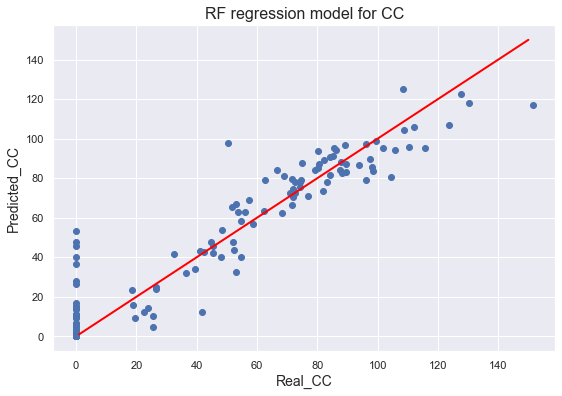

In [436]:
plt.rcParams["figure.figsize"] = (9,6)
plt.scatter(x=y_test, y=y_pred)
plt.plot([1,150], [1,150], color="red", linewidth=2)
plt.xlabel("Real_CC", fontsize=14)
plt.ylabel("Predicted_CC", fontsize=14)
plt.title("RF regression model for CC", fontsize=16)
plt.show

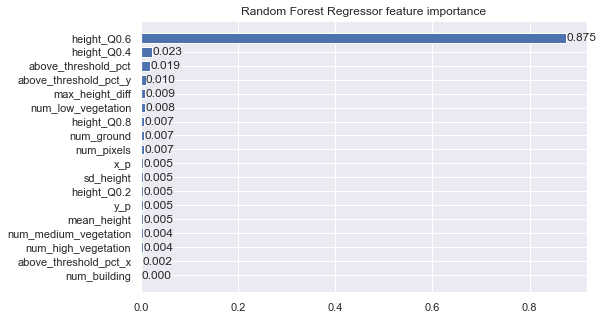

In [437]:
plt.rcParams["figure.figsize"] = (8,5)
sorted_index = regressor.feature_importances_.argsort()
parameters = list(X_train.columns)
plt.barh([parameters[i] for i in sorted_index], regressor.feature_importances_[sorted_index], height=.7)
plt.title('Random Forest Regressor feature importance')
for x, y_ in zip(regressor.feature_importances_[sorted_index], np.arange(len(parameters))):
    plt.text(x + .001, y_, f'{x:.3f}', va='center')
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### XGBoost regressor model

In [438]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

param = {
    'eta': 0.3, 
    'nthread': 4,
    'max_depth': 3,
    'min_child_weight': 5,
    'colsample_bytree': 0.5,
    'objective': 'reg:linear'
}

evallist = [(dvalid, 'eval'), (dtrain, 'train')]

num_round = 50
xgb_model = xgb.train(param, dtrain, num_round, evallist, verbose_eval = 25)

y_pred = xgb_model.predict(xgb.DMatrix(X_test))
y_pred_train = xgb_model.predict(xgb.DMatrix(X_train))
R2_train = r2_score(y_train, y_pred_train)
R2_test = r2_score(y_test, y_pred)
print("=="*50)
print('R2 score (on train):', R2_train)
print('R2 score (on test):', R2_test)

[22:22:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	eval-rmse:37.62797	train-rmse:38.17282
[25]	eval-rmse:11.31322	train-rmse:6.49294
[49]	eval-rmse:11.06019	train-rmse:4.57987
R2 score (on train): 0.986796740004192
R2 score (on test): 0.9246417833234666


<function matplotlib.pyplot.show(close=None, block=None)>

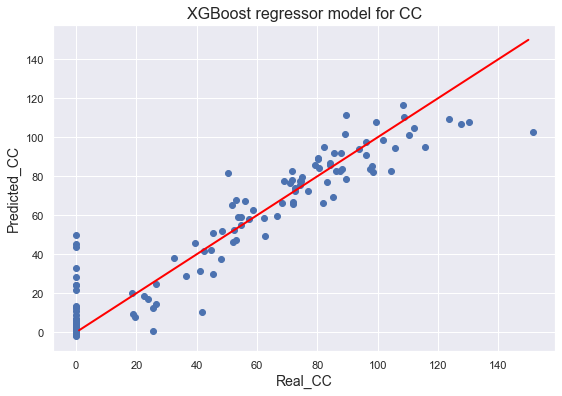

In [439]:
plt.rcParams["figure.figsize"] = (9,6)
plt.scatter(x=y_test, y=y_pred)
plt.plot([1,150], [1,150], color="red", linewidth=2)
plt.xlabel("Real_CC", fontsize=14)
plt.ylabel("Predicted_CC", fontsize=14)
plt.title("XGBoost regressor model for CC", fontsize=16)
plt.show

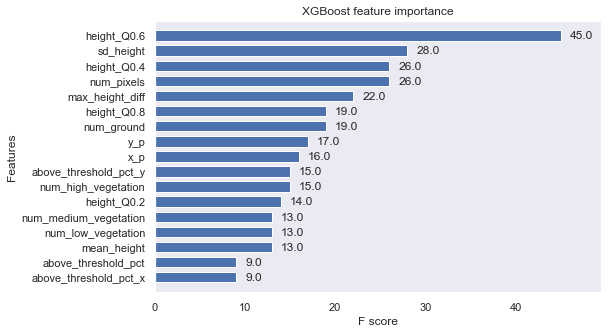

In [440]:
plt.rcParams["figure.figsize"] = (8,5)
plot_importance(xgb_model, height=0.7, grid=False, title="XGBoost feature importance")
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]